## Imports
---

In [41]:
import pandas as pd
import numpy as np
import plotly.express as px
from src.utils.dataset import get_full_transactions_dataset 

from sklearn import preprocessing

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## Data set load
---

In [2]:
df = get_full_transactions_dataset()

2025-02-24 21:59:47.858 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-02-24 21:59:47.859 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-24 21:59:48.277 
  command:

    streamlit run C:\Users\ferna\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-24 21:59:48.277 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-24 21:59:48.278 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-24 21:59:48.782 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-24 21:59:48.785 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-24 21:59:56.836 Thread 'Ma

In [3]:
df.shape

(4484942, 9)

In [4]:
df.head(3)

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,3208_8000F4580,1_8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
1,2022/09/01 00:26,12_8000EC280,2439_8017BF800,7.66,US Dollar,7.66,US Dollar,Credit Card,0
2,2022/09/01 00:21,1_8000EDEC0,211050_80AEF5310,383.71,US Dollar,383.71,US Dollar,Credit Card,0


In [5]:
df.columns

Index(['timestamp', 'sender', 'receiver', 'amount_received',
       'receiving_currency', 'amount_paid', 'payment_currency',
       'payment_format', 'is_laundering'],
      dtype='object')

## Exploratory analysis
---

In [6]:
df.dtypes

timestamp              object
sender                 object
receiver               object
amount_received       float64
receiving_currency     object
amount_paid           float64
payment_currency       object
payment_format         object
is_laundering           int64
dtype: object

In [7]:
df.isna().sum()

timestamp             0
sender                0
receiver              0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

In [8]:
df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,3208_8000F4580,1_8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
1,2022/09/01 00:26,12_8000EC280,2439_8017BF800,7.66,US Dollar,7.66,US Dollar,Credit Card,0
2,2022/09/01 00:21,1_8000EDEC0,211050_80AEF5310,383.71,US Dollar,383.71,US Dollar,Credit Card,0
3,2022/09/01 00:04,1_8000F4510,11813_8011305D0,9.82,US Dollar,9.82,US Dollar,Credit Card,0
4,2022/09/01 00:08,1_8000F4FE0,245335_812ED62E0,4.01,US Dollar,4.01,US Dollar,Credit Card,0


### Accounts

In [9]:
senders = df.sender.unique().tolist()
receivers = df.receiver.unique().tolist()
all_customers = set(senders + receivers)

In [10]:
print(f"Number of unique senders: {len(senders)}")
print(f"Number of unique receivers: {len(receivers)}")
print(f"Number of unique receivers: {len(all_customers)}")

Number of unique senders: 305756
Number of unique receivers: 284340
Number of unique receivers: 422690


### Currency

In [11]:
df["payment_currency"].unique()

array(['US Dollar', 'Bitcoin', 'Euro', 'Australian Dollar', 'Yuan',
       'Rupee', 'Mexican Peso', 'UK Pound', 'Canadian Dollar',
       'Swiss Franc', 'Yen', 'Brazil Real', 'Shekel', 'Ruble',
       'Saudi Riyal'], dtype=object)

In [12]:
currency_count = df.payment_currency.value_counts().reset_index()
fig = px.pie(
    currency_count,
    values="count",
    names="payment_currency",
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

### Payment format

In [13]:
payment_format_count = df.payment_format.value_counts().reset_index()
fig = px.pie(
    payment_format_count,
    values='count',
    names='payment_format',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

### Frauds

In [14]:
frauds_count = df.is_laundering.value_counts().reset_index()
frauds_count["is_laundering"] = frauds_count["is_laundering"].map({1: "True", 0: "False"})

In [15]:
frauds_count

,is_laundering,count
0,False,4479776
1,True,5166


In [16]:
fig = px.pie(
    frauds_count,
    values="count",
    names="is_laundering",
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

### Timestamp

In [17]:
df ["timestamp"] = pd.to_datetime(df['timestamp'])
df["hour"] = df["timestamp"].dt.hour
df["week_day"] = df["timestamp"].dt.day_name()
df["week_day_number"] = df["timestamp"].dt.day_of_week

In [18]:
timestamp_no_fraud_df = df.groupby(["week_day", "week_day_number", "hour"], as_index=False).sender.count().rename(columns={"sender": "count"})
timestamp_no_fraud_df = timestamp_no_fraud_df.sort_values(by=["week_day_number", "hour"])

timestamp_fraud_df = df[df["is_laundering"] == 1].groupby(["week_day", "week_day_number", "hour"], as_index=False).sender.count().rename(columns={"sender": "count"})
timestamp_fraud_df = timestamp_fraud_df.sort_values(by=["week_day_number", "hour"])

In [19]:
px.density_heatmap(timestamp_no_fraud_df, x='week_day', y='hour', z='count', color_continuous_scale='Viridis').show()
px.density_heatmap(timestamp_fraud_df, x='week_day', y='hour', z='count', color_continuous_scale='Viridis').show()

## Data preparation
---

### Node features

In [20]:
accounts_df = set(set(df['sender']).union(set(df['receiver'])))
nodes_df = pd.DataFrame({'account': list(accounts_df)})
nodes_df = nodes_df.sort_values(by="account").reset_index(drop=True)

In [21]:
laundering_df = df[df["is_laundering"] == 1]
laundering_accounts_df = set(set(laundering_df['sender']).union(set(laundering_df['receiver'])))

In [22]:
nodes_df["is_laundering"] = nodes_df.account.apply(lambda account_id: 1 if account_id in laundering_accounts_df else 0)

In [23]:
nodes_df["transactions_sent"] = nodes_df['account'].map(df.groupby('sender').size()).fillna(0)
nodes_df['transactions_received'] = nodes_df['account'].map(df.groupby('receiver').size()).fillna(0)
nodes_df['unique_currencies_sent'] = nodes_df['account'].map(df.groupby('sender')['payment_currency'].nunique()).fillna(0)
nodes_df['unique_currencies_received'] = nodes_df['account'].map(df.groupby('receiver')['payment_currency'].nunique()).fillna(0)

In [24]:
currencies = set(set(df['payment_currency']).union(set(df['receiving_currency'])))
for currency in currencies:
    nodes_df[f'total_sent_{currency.lower()}'] = nodes_df['account'].map(
        df[df['payment_currency'] == currency].groupby('sender')['amount_paid'].sum()
    ).fillna(0)
    
    nodes_df[f'total_received_{currency.lower()}'] = nodes_df['account'].map(
        df[df['payment_currency'] == currency].groupby('receiver')['amount_paid'].sum()
    ).fillna(0)

In [25]:
node_labels = torch.from_numpy(nodes_df["is_laundering"].values).to(torch.long)
node_features_df = nodes_df.drop(["account", "is_laundering"], axis=1)
node_features = torch.from_numpy(node_features_df.values).to(torch.float)

### Edge features

In [26]:
edges_df = df[["timestamp", "sender", "receiver", "amount_paid", "payment_currency", "payment_format", "is_laundering"]].copy()
le = preprocessing.LabelEncoder()
for i in ["payment_currency", "payment_format"]:
    edges_df[i] = le.fit_transform(edges_df[i].astype(str))

In [27]:
account_to_index = {acc: idx for idx, acc in enumerate(nodes_df['account'])}

In [28]:
edges_df['sender'] = edges_df['sender'].map(account_to_index)
edges_df['receiver'] = edges_df['receiver'].map(account_to_index)

In [29]:
edges_df['timestamp'] = edges_df['timestamp'].astype('int64') // 10**9

In [30]:
scaler = StandardScaler()
edges_df[['timestamp', 'amount_paid']] = scaler.fit_transform(edges_df[['timestamp', 'amount_paid']])

In [31]:
edges_df.head()

,timestamp,sender,receiver,amount_paid,payment_currency,payment_format,is_laundering
0,-1.587407,307284,155718,-0.005165,12,3,0
1,-1.586006,65984,237568,-0.005165,12,4,0
2,-1.587173,155706,165004,-0.005164,12,4,0
3,-1.591141,155713,35484,-0.005165,12,4,0
4,-1.590207,155717,240439,-0.005165,12,4,0


In [32]:
edge_index = torch.tensor([edges_df['sender'].values, edges_df['receiver'].values], dtype=torch.long)
edge_attr = torch.tensor(edges_df.drop(columns=['sender', 'receiver']).values, dtype=torch.float)

C:\Users\ferna\AppData\Local\Temp\ipykernel_40164\3673241595.py:1: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)



### Graph data

In [33]:
graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=node_labels)

In [34]:
graph_data

Data(x=[422690, 34], edge_index=[2, 4484942], edge_attr=[4484942, 5], y=[422690])

## Training
---

### Model definition

In [35]:
class GATModel(torch.nn.Module):
    def __init__(self, in_feats, hidden_dim, out_feats, heads=2):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_feats, hidden_dim, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, out_feats, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

### Train and test split

In [36]:
num_nodes = graph_data.x.shape[0]
train_idx, test_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

### Train

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_feats=graph_data.x.shape[1], hidden_dim=16, out_feats=2).to(device)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
graph_data = graph_data.to(device)

In [39]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    out = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 396049440.0000
Epoch 10, Loss: 275755776.0000
Epoch 20, Loss: 188609168.0000
Epoch 30, Loss: 167289344.0000
Epoch 40, Loss: 92396872.0000
Epoch 50, Loss: 73096368.0000
Epoch 60, Loss: 33916628.0000
Epoch 70, Loss: 35877148.0000
Epoch 80, Loss: 34805012.0000
Epoch 90, Loss: 33274052.0000


### Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
    predictions = logits.argmax(dim=1).cpu().numpy()
    true_labels = graph_data.y.cpu().numpy()

test_preds = predictions[graph_data.test_mask.cpu().numpy()]
test_labels = true_labels[graph_data.test_mask.cpu().numpy()]

accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
conf_matrix = confusion_matrix(test_labels, test_preds)

labels = ["Não Lavador (0)", "Lavador (1)"]
conf_matrix_display = np.array([
    [f"TN: {conf_matrix[0,0]}", f"FP: {conf_matrix[0,1]}"],
    [f"FN: {conf_matrix[1,0]}", f"TP: {conf_matrix[1,1]}"]
])

print(f"📊 Acurácia: {accuracy:.4f}")
print(f"🎯 Precisão: {precision:.4f}")
print(f"📢 Recall: {recall:.4f}")
print(f"📈 F1-score: {f1:.4f}")

📊 Acurácia: 0.9684
🎯 Precisão: 0.0319
📢 Recall: 0.0380
📈 F1-score: 0.0347


C:\Users\ferna\AppData\Local\Temp\ipykernel_40164\1396749732.py:32: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [44]:
%matplotlib inline

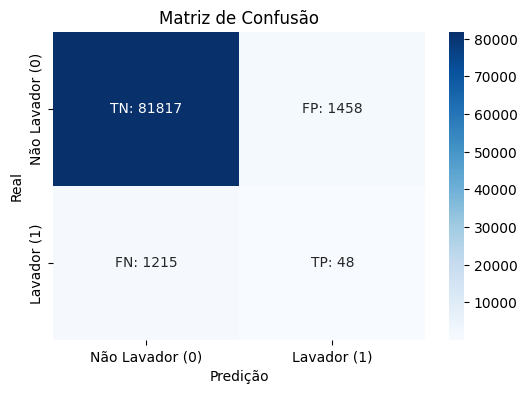

In [46]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=conf_matrix_display, fmt="", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()